# Catalyst classification tutorial

Authors: [Roman Tezikov](https://github.com/TezRomacH), [Sergey Kolesnikov](https://github.com/Scitator)

[![Catalyst logo](https://raw.githubusercontent.com/catalyst-team/catalyst-pics/master/pics/catalyst_logo.png)](https://github.com/catalyst-team/catalyst)

### Colab setup

First of all, do not forget to change the runtime type to GPU. <br/>
To do so click `Runtime` -> `Change runtime type` -> Select `"Python 3"` and `"GPU"` -> click `Save`. <br/>
After that you can click `Runtime` -> `Run` all and watch the tutorial.

## Requirements

Download and install the latest version of catalyst and other libraries required for this tutorial.

In [1]:
# this variable will be used in `runner.train` and by default we disable FP16 mode
is_fp16_used = False

In [2]:
# for augmentations
!pip install albumentations

# for pretrained models for PyTorch
!pip install pretrainedmodels


################
# Catalyst itself
!pip install -U catalyst
# For specific version of catalyst, uncomment:
# ! pip install git+http://github.com/catalyst-team/catalyst.git@{master/commit_hash}
################

# for TTA
# !pip install ttach

# for tensorboard
!pip install tensorflow
%load_ext tensorboard


# if Your machine support Apex FP16, uncomment this 3 lines below
# !git clone https://github.com/NVIDIA/apex
# !pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex
# is_fp16_used = True

     |████████████████████████████████| 634kB 7.7MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp37-none-any.whl size=654019 sha256=44f516fdae2778ef26018c5da05a95fdd22e1006fc9923fccfd797341ee45b47
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
     |████████████████████████████████| 61kB 4.6MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60963 sha256=781684247bb4a16341f3b20cb16a3b5617f96cddd0f8fc796504698edfb94d3c
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels
     |████████████████████████████████| 512kB 7.8MB/s 
     |████████████████████████████████| 645kB 15.0MB/s 
     |████████████████████████████████| 122kB 26.2MB/s 
  Foun

### Colab extras – Plotly

To intergate visualization library `plotly` to colab, run

In [3]:
import IPython

def configure_plotly_browser_state():
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))


IPython.get_ipython().events.register('pre_run_cell', configure_plotly_browser_state)

## Setting up GPUs

In [6]:
from typing import Callable, List, Tuple 

import os
import torch
import catalyst

from catalyst import utils

print(f"torch: {torch.__version__}, catalyst: {catalyst.__version__}")

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # "" - CPU, "0" - 1 GPU, "0,1" - MultiGPU

SEED = 42
utils.set_global_seed(SEED)
utils.prepare_cudnn(deterministic=True)

torch: 1.8.1+cu101, catalyst: 21.04.2


-------

## Dataset

As a dataset we will take [Best Artworks of All Time](https://www.kaggle.com/ikarus777/best-artworks-of-all-time) - collection of Paintings of the 50 Most Influential Artists of All Time.

> If you are on MacOS and you don’t have `wget`, you can install it with: `brew install wget`.

After Catalyst installation, `download-gdrive` function become available to download objects from Google Drive.
We use it to download datasets.

usage: `download-gdrive {FILE_ID} {FILENAME}`

In [7]:
%%bash

download-gdrive 1eAk36MEMjKPKL5j9VWLvNTVKk4ube9Ml artworks.tar.gz
extract-archive artworks.tar.gz &>/dev/null

Output hidden; open in https://colab.research.google.com to view.

In [8]:
from pathlib import Path

ROOT = "artworks/"
ALL_IMAGES = list(Path(ROOT).glob("**/*.jpg"))
ALL_IMAGES = list(filter(lambda x: not x.name.startswith("."), ALL_IMAGES))
print("Number of images:", len(ALL_IMAGES))

Number of images: 8446


Let's check out the data!

In [9]:
from catalyst.utils import imread
import numpy as np

import matplotlib.pyplot as plt

def show_examples(images: List[Tuple[str, np.ndarray]]):
    _indexes = [(i, j) for i in range(2) for j in range(2)]
    
    f, ax = plt.subplots(2, 2, figsize=(16, 16))
    for (i, j), (title, img) in zip(_indexes, images):
        ax[i, j].imshow(img)
        ax[i, j].set_title(title)
    f.tight_layout()

def read_random_images(paths: List[Path]) -> List[Tuple[str, np.ndarray]]:
    data = np.random.choice(paths, size=4)
    result = []
    for d in data:
        title = f"{d.parent.name}: {d.name}"
        _image = imread(d)
        result.append((title, _image))
    
    return result

You can restart the cell below to see more examples.

In [10]:
images = read_random_images(ALL_IMAGES)
show_examples(images)

## Dataset preprocessing

With Catalyst we can easily create a dataset from the following folder structure:
```
dataset/
    class_1/
        *.ext
        ...
    class_2/
        *.ext
        ...
    ...
    class_N/
        *.ext
        ...
```

First of all `create_dataset` function goes through a given directory and creates a dictionary `Dict[class_name, List[image]]`. <br/>
Then `create_dataframe` function creates typical `pandas.DataFrame` for further analysis. <br/>
After than `prepare_dataset_labeling` creates a numerical label for each unique class name. <br/>
Finally, to add a column with a numerical label value to the DataFrame, we can use `map_dataframe` function.

Additionaly let's save the `class_names` for further usage.

In [20]:
from catalyst.contrib.utils.pandas import create_dataset, create_dataframe#, prepare_dataset_labeling
from catalyst.contrib.utils.pandas import map_dataframe

dataset = create_dataset(dirs=f"{ROOT}/*", extension="*.jpg")
df = create_dataframe(dataset, columns=["class", "filepath"])

tag_to_label = {k: i for i, k in enumerate(sorted(np.unique(df['class'])))} # prepare_dataset_labeling(df, "class")
class_names = [name for name, id_ in sorted(tag_to_label.items(), key=lambda x: x[1])]

df_with_labels = map_dataframe(
    df, 
    tag_column="class", 
    class_column="label", 
    tag2class=tag_to_label, 
    verbose=False
)
df_with_labels.head()

class                                          filepath  label
0  Albrecht_Dürer    artworks/Albrecht_Dürer/Albrecht_Dürer_1.jpg      0
1  Albrecht_Dürer   artworks/Albrecht_Dürer/Albrecht_Dürer_10.jpg      0
2  Albrecht_Dürer  artworks/Albrecht_Dürer/Albrecht_Dürer_100.jpg      0
3  Albrecht_Dürer  artworks/Albrecht_Dürer/Albrecht_Dürer_101.jpg      0
4  Albrecht_Dürer  artworks/Albrecht_Dürer/Albrecht_Dürer_102.jpg      0

Now let's divide our dataset into the `train` and` valid` parts. <br/>
The parameters for the split_dataframe function are the same as [sklearn.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn-model-selection-train-test-split). <br/>
We also define `test_size` (it is optional) and `random_state` for reproducibility.

In [22]:
from catalyst.contrib.utils.pandas import split_dataframe

train_data, valid_data = split_dataframe( df_with_labels, test_size=0.2, random_state=SEED)
train_data, valid_data = train_data.to_dict('records'), valid_data.to_dict('records')

TypeError: ignored

In order to save your time during data preparation/reading/writing, Catalyst provides a special abstraction – [Reader](https://catalyst-team.github.io/catalyst/api/data.html#reader). <br/> 
Reader allows you to read various structures, for example, images, strings, numerical values and perform some functions on top of them.

In [ ]:
from catalyst.dl import utils
from catalyst.data.reader import ImageReader, ScalarReader, ReaderCompose

num_classes = len(tag_to_label)

# ReaderCompose collects different Readers into one pipeline
open_fn = ReaderCompose([
    
    # Reads images from the `datapath` folder 
    # using the key `input_key =" filepath "` (here should be the filename)
    # and writes it to the output dictionary by `output_key="features"` key
    ImageReader(
        input_key="filepath",
        output_key="features",
        datapath=ROOT
    ),
    
    # Reads a number from our dataframe 
    # by the key `input_key =" label "` to np.long
    # and writes it to the output dictionary by `output_key="targets"` key
    ScalarReader(
        input_key="label",
        output_key="targets",
        default_value=-1,
        dtype=np.int64
    ),
    
    # Same as above, but with one encoding
    ScalarReader(
        input_key="label",
        output_key="targets_one_hot",
        default_value=-1,
        dtype=np.int64, 
        one_hot_classes=num_classes
    )
])

-------

## Augmentations

[![Albumentation logo](https://albumentations.readthedocs.io/en/latest/_static/logo.png)](https://github.com/albu/albumentations)

The [albumentation](https://github.com/albu/albumentations) library works with images and masks at the same time, which is what we need.

In [ ]:
import albumentations as albu
from albumentations.pytorch import ToTensor

BORDER_CONSTANT = 0
BORDER_REFLECT = 2

def pre_transforms(image_size=224):
    # Convert the image to a square of size image_size x image_size
    # (keeping aspect ratio)
    result = [
        albu.LongestMaxSize(max_size=image_size),
        albu.PadIfNeeded(image_size, image_size, border_mode=BORDER_CONSTANT)
    ]
    
    return result

def hard_transforms():
    result = [
        # Random shifts, stretches and turns with a 50% probability
        albu.ShiftScaleRotate( 
            shift_limit=0.1,
            scale_limit=0.1,
            rotate_limit=15,
            border_mode=BORDER_REFLECT,
            p=0.5
        ),
        albu.IAAPerspective(scale=(0.02, 0.05), p=0.3),
        # Random brightness / contrast with a 30% probability
        albu.RandomBrightnessContrast(
            brightness_limit=0.2, contrast_limit=0.2, p=0.3
        ),
        # Random gamma changes with a 30% probability
        albu.RandomGamma(gamma_limit=(85, 115), p=0.3),
        # Randomly changes the hue, saturation, and color value of the input image
        albu.HueSaturationValue(p=0.3),
        albu.JpegCompression(quality_lower=80),
    ]
    
    return result

def post_transforms():
    # we use ImageNet image normalization
    # and convert it to torch.Tensor
    return [albu.Normalize(), ToTensor()]

def compose(transforms_to_compose):
    # combine all augmentations into one single pipeline
    result = albu.Compose([
      item for sublist in transforms_to_compose for item in sublist
    ])
    return result

Like Reader, there is a close abstraction for handling augmentations and key-value-based dataloaders – [Augmentor](https://catalyst-team.github.io/catalyst/api/data.html#augmentor).

In [ ]:
from catalyst.data.augmentor import Augmentor


train_transforms = compose([
    pre_transforms(), 
    hard_transforms(), 
    post_transforms()
])
valid_transforms = compose([pre_transforms(), post_transforms()])

show_transforms = compose([pre_transforms(), hard_transforms()])

# Takes an image from the input dictionary by the key `dict_key` 
# and performs `train_transforms` on it.
train_data_transforms = Augmentor(
    dict_key="features",
    augment_fn=lambda x: train_transforms(image=x)["image"]
)


# Similarly for the validation part of the dataset. 
# we only perform squaring, normalization and ToTensor
valid_data_transforms = Augmentor(
    dict_key="features",
    augment_fn=lambda x: valid_transforms(image=x)["image"]
)

Let's look at the augmented results. <br/>
You can restart the cell below to see more examples of augmentations.

In [ ]:
images = read_random_images(ALL_IMAGES)

images = [
    (title, show_transforms(image=i)["image"])
    for (title, i) in images
]
show_examples(images)

-------

## Loaders

Using `catalyst.utils.get_loader`, you can immediately get loaders only from the dataset and data-converting functions.

In [5]:
import collections

def get_loaders(
    open_fn: Callable,
    train_transforms_fn,
    valid_transforms_fn,
    batch_size: int = 64, 
    num_workers: int = 4,
    sampler = None
) -> collections.OrderedDict:
    """
    Args:
        open_fn: Reader for reading data from a dataframe
        train_transforms_fn: Augmentor for train part
        valid_transforms_fn: Augmentor for valid part
        batch_size: batch size
        num_workers: How many subprocesses to use to load data,
        sampler: An object of the torch.utils.data.Sampler class 
            for the dataset data sampling strategy specification
    """
    train_loader = utils.get_loader(
        train_data,
        open_fn=open_fn,
        dict_transform=train_transforms_fn,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=sampler is None, # shuffle data only if Sampler is not specified (PyTorch requirement)
        sampler=sampler,
        drop_last=True,
    )

    valid_loader = utils.get_loader(
        valid_data,
        open_fn=open_fn,
        dict_transform=valid_transforms_fn,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False, 
        sampler=None,
        drop_last=True,
    )

    # Catalyst expects an ordered dictionary with train/valid/infer loaders. 
    # The number of loaders can vary.
    # For example, it can easily handle even some complex logic like:
    # loaders["train_dataset1"] = train_loader_1
    # loaders["train_dataset2"] = train_loader_2
    # ....
    # loaders["valid_1"] = valid_loader_1
    # loaders["valid_2"] = valid_loader_2
    # ...
    # loaders["infer_1"] = infer_loader_1
    # loaders["infer_2"] = infer_loader_2
    # ...
    
    loaders = collections.OrderedDict()
    loaders["train"] = train_loader
    loaders["valid"] = valid_loader

    return loaders

if is_fp16_used:
    batch_size = 128
else:
    batch_size = 64

print(f"batch_size: {batch_size}")

loaders = get_loaders(
    open_fn=open_fn, 
    train_transforms_fn=train_data_transforms,
    valid_transforms_fn=valid_data_transforms,
    batch_size=batch_size,
)


batch_size: 64


NameError: ignored

-------

## Experiment
### Model

Let's take the classification model from [Cadene pretrain models](https://github.com/Cadene/pretrained-models.pytorch). This repository contains a huge number of pre-trained PyTorch models.

**> Мы вместо этого используем [EfficientNet-PyTorch](https://github.com/lukemelas/EfficientNet-PyTorch)**

In [ ]:
!pip install --upgrade efficientnet-pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.5.1-cp36-none-any.whl size=11768 sha256=4c14ee5ca44ebaa791b4e4e8e5f3e7b7021f509d91ff58808289a77297aa02b6
  Stored in directory: /root/.cache/pip/wheels/52/0c/8e/58d91f29f0f8cbb45231a145312939a5423dc82c61cc731361
Successfully built efficientnet-pytorch


In [ ]:
from torch import nn
# import pretrainedmodels
from efficientnet_pytorch import EfficientNet

def get_model(model_name: str, num_classes: int, pretrained: str = "imagenet"):
    # model_fn = pretrainedmodels.__dict__[model_name]
    # model = model_fn(num_classes=1000, pretrained=pretrained)
    
    # model._fc = nn.Sequential()
    # dim_feats = model.last_linear.in_features
    # model.last_linear = nn.Linear(dim_feats, num_classes)

    model = EfficientNet.from_pretrained(model_name, num_classes=num_classes) #.cuda()

    return model

model_name = 'efficientnet-b1'
model = get_model(model_name, num_classes)
model

Loaded pretrained weights for efficientnet-b1


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

### Model training

In [ ]:
import torch

# as we are working on basic classification problem (no multi-class/multi-label)
# let's use standard CE loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[9], gamma=0.3
)

To run some DL experiment, Catalyst uses a [Runner](https://catalyst-team.github.io/catalyst/api/dl.html#catalyst.dl.core.runner.Runner) abstraction. <br/>
It contains main logic about "how" you run the experiment and getting predictions.

For supervised learning case, there is an extention for Runner – [SupervisedRunner](https://catalyst-team.github.io/catalyst/api/dl.html#module-catalyst.dl.runner.supervised), which provides additional methods like `train`, `infer` and `predict_loader`.

In [ ]:
from catalyst.dl.runner import SupervisedRunner

num_epochs = 10
logdir = "./logs/classification"

device = utils.get_device()
print(f"device: {device}")

if is_fp16_used:
    fp16_params = dict(opt_level="O1") # params for FP16
else:
    fp16_params = None

print(f"FP16 params: {fp16_params}")

runner = SupervisedRunner(device=device)

device: cuda
FP16 params: None


Using [Callbacks](https://catalyst-team.github.io/catalyst/api/dl.html#catalyst.dl.core.callback.Callback), the basic functionality of the catalyst can be expanded.

A callback is a class inherited from `catalyst.dl.core.Callback` and implements one / several / all methods:

```
on_stage_start
    --- on_epoch_start
    ------ on_loader_start
    --------- on_batch_start
    --------- on_batch_end
    ------ on_loader_end
    --- on_epoch_end
on_stage_end

on_exception - if the code crashes with an error, you can catch it and reserve the parameters you need
```

You can find the list of standard callbacks [here](https://catalyst-team.github.io/catalyst/api/dl.html#module-catalyst.dl.callbacks.checkpoint). 
It includes callbacks such as
- CheckpointCallback. Saves N best models in logdir
- TensorboardLogger. Logs all metrics to tensorboard
- EarlyStoppingCallback. Early training stop if metrics do not improve for the `patience` of epochs
- ConfusionMatrixCallback. Plots ConfusionMatrix per epoch in tensorboard

Many different metrics for classfication
- AccuracyCallback
- MapKCallback
- AUCCallback
- F1ScoreCallback

segmentation
- DiceCallback
- IouCallback

and many other callbacks, like LRFinder and MixupCallback

### Monitoring in tensorboard

If you do not have a Tensorboard opened after you have run the cell below, try running the cell again.

In [ ]:
%tensorboard --logdir {logdir}

### Running train-loop

In [ ]:
# as we are working on classification task
from catalyst.dl.callbacks import AccuracyCallback, AUCCallback, F1ScoreCallback

runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    # We can specify the callbacks list for the experiment;
    # For this task, we will check accuracy, AUC and F1 metrics
    callbacks=[
        AccuracyCallback(num_classes=num_classes),
        AUCCallback(
            num_classes=num_classes,
            input_key="targets_one_hot",
            class_names=class_names
        ),
        F1ScoreCallback(
            input_key="targets",
            activation="Softmax"
        )
    ],
    # path to save logs
    logdir=logdir,
    
    num_epochs=num_epochs,
    
    # save our best checkpoint by AUC metric
    main_metric="auc/_mean",
    # AUC needs to be maximized.
    minimize_metric=False,
    
    # for FP16. It uses the variable from the very first cell
    fp16=fp16_params,
    
    # prints train logs
    verbose=True
)

1/10 * Epoch (train):   1% 1/105 [00:08<14:50,  8.57s/it, accuracy01=4.688, accuracy03=10.938, accuracy05=20.312, f1_score=0.021, loss=3.906]

/usr/local/lib/python3.6/dist-packages/catalyst/dl/utils/criterion/f1_score.py:31: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



1/10 * Epoch (train): 100% 105/105 [02:22<00:00,  1.17it/s, accuracy01=53.125, accuracy03=68.750, accuracy05=76.562, f1_score=0.340, loss=1.917]
1/10 * Epoch (valid): 100% 26/26 [00:28<00:00,  1.50it/s, accuracy01=51.562, accuracy03=70.312, accuracy05=84.375, f1_score=0.343, loss=1.745]
[2019-12-05 22:53:16,328] 
1/10 * Epoch 1 (train): _base/lr=0.0003 | _base/momentum=0.9000 | _timers/_fps=457.5391 | _timers/batch_time=0.7036 | _timers/data_time=0.5880 | _timers/model_time=0.1155 | accuracy01=32.1577 | accuracy03=51.3244 | accuracy05=61.2798 | auc/_mean=0.8019 | auc/class_Albrecht_Dürer=0.9554 | auc/class_Alfred_Sisley=0.9299 | auc/class_Amedeo_Modigliani=0.8739 | auc/class_Andrei_Rublev=0.8365 | auc/class_Andy_Warhol=0.9068 | auc/class_Camille_Pissarro=0.8129 | auc/class_Caravaggio=0.8401 | auc/class_Claude_Monet=0.7689 | auc/class_Diego_Rivera=0.6581 | auc/class_Diego_Velazquez=0.7643 | auc/class_Edgar_Degas=0.8503 | auc/class_Edouard_Manet=0.7121 | auc/class_Edvard_Munch=0.6001 | a

INFO:metrics_logger:
1/10 * Epoch 1 (train): _base/lr=0.0003 | _base/momentum=0.9000 | _timers/_fps=457.5391 | _timers/batch_time=0.7036 | _timers/data_time=0.5880 | _timers/model_time=0.1155 | accuracy01=32.1577 | accuracy03=51.3244 | accuracy05=61.2798 | auc/_mean=0.8019 | auc/class_Albrecht_Dürer=0.9554 | auc/class_Alfred_Sisley=0.9299 | auc/class_Amedeo_Modigliani=0.8739 | auc/class_Andrei_Rublev=0.8365 | auc/class_Andy_Warhol=0.9068 | auc/class_Camille_Pissarro=0.8129 | auc/class_Caravaggio=0.8401 | auc/class_Claude_Monet=0.7689 | auc/class_Diego_Rivera=0.6581 | auc/class_Diego_Velazquez=0.7643 | auc/class_Edgar_Degas=0.8503 | auc/class_Edouard_Manet=0.7121 | auc/class_Edvard_Munch=0.6001 | auc/class_El_Greco=0.7830 | auc/class_Eugene_Delacroix=0.7127 | auc/class_Francisco_Goya=0.8360 | auc/class_Frida_Kahlo=0.7943 | auc/class_Georges_Seurat=0.6913 | auc/class_Giotto_di_Bondone=0.8858 | auc/class_Gustav_Klimt=0.7925 | auc/class_Gustave_Courbet=0.7018 | auc/class_Henri_Matisse=0.88

2/10 * Epoch (train): 100% 105/105 [02:17<00:00,  1.36it/s, accuracy01=71.875, accuracy03=89.062, accuracy05=93.750, f1_score=0.513, loss=0.990]
2/10 * Epoch (valid): 100% 26/26 [00:27<00:00,  1.68it/s, accuracy01=71.875, accuracy03=87.500, accuracy05=93.750, f1_score=0.536, loss=1.093]
[2019-12-05 22:56:02,424] 
2/10 * Epoch 2 (train): _base/lr=0.0003 | _base/momentum=0.9000 | _timers/_fps=529.6276 | _timers/batch_time=0.6468 | _timers/data_time=0.5482 | _timers/model_time=0.0983 | accuracy01=61.1458 | accuracy03=80.0595 | accuracy05=86.9494 | auc/_mean=0.9484 | auc/class_Albrecht_Dürer=0.9942 | auc/class_Alfred_Sisley=0.9870 | auc/class_Amedeo_Modigliani=0.9913 | auc/class_Andrei_Rublev=0.9774 | auc/class_Andy_Warhol=0.9840 | auc/class_Camille_Pissarro=0.9160 | auc/class_Caravaggio=0.9590 | auc/class_Claude_Monet=0.9308 | auc/class_Diego_Rivera=0.9273 | auc/class_Diego_Velazquez=0.9209 | auc/class_Edgar_Degas=0.9767 | auc/class_Edouard_Manet=0.9036 | auc/class_Edvard_Munch=0.8790 | a

INFO:metrics_logger:
2/10 * Epoch 2 (train): _base/lr=0.0003 | _base/momentum=0.9000 | _timers/_fps=529.6276 | _timers/batch_time=0.6468 | _timers/data_time=0.5482 | _timers/model_time=0.0983 | accuracy01=61.1458 | accuracy03=80.0595 | accuracy05=86.9494 | auc/_mean=0.9484 | auc/class_Albrecht_Dürer=0.9942 | auc/class_Alfred_Sisley=0.9870 | auc/class_Amedeo_Modigliani=0.9913 | auc/class_Andrei_Rublev=0.9774 | auc/class_Andy_Warhol=0.9840 | auc/class_Camille_Pissarro=0.9160 | auc/class_Caravaggio=0.9590 | auc/class_Claude_Monet=0.9308 | auc/class_Diego_Rivera=0.9273 | auc/class_Diego_Velazquez=0.9209 | auc/class_Edgar_Degas=0.9767 | auc/class_Edouard_Manet=0.9036 | auc/class_Edvard_Munch=0.8790 | auc/class_El_Greco=0.9656 | auc/class_Eugene_Delacroix=0.9411 | auc/class_Francisco_Goya=0.9470 | auc/class_Frida_Kahlo=0.9540 | auc/class_Georges_Seurat=0.9193 | auc/class_Giotto_di_Bondone=0.9863 | auc/class_Gustav_Klimt=0.9364 | auc/class_Gustave_Courbet=0.9094 | auc/class_Henri_Matisse=0.95

3/10 * Epoch (train): 100% 105/105 [02:16<00:00,  1.19it/s, accuracy01=68.750, accuracy03=85.938, accuracy05=95.312, f1_score=0.575, loss=1.065]
3/10 * Epoch (valid): 100% 26/26 [00:27<00:00,  1.57it/s, accuracy01=76.562, accuracy03=90.625, accuracy05=95.312, f1_score=0.650, loss=0.887]
[2019-12-05 22:58:47,076] 
3/10 * Epoch 3 (train): _base/lr=0.0003 | _base/momentum=0.9000 | _timers/_fps=479.7203 | _timers/batch_time=0.6298 | _timers/data_time=0.5297 | _timers/model_time=0.1000 | accuracy01=75.0000 | accuracy03=90.1190 | accuracy05=94.2262 | auc/_mean=0.9742 | auc/class_Albrecht_Dürer=0.9975 | auc/class_Alfred_Sisley=0.9910 | auc/class_Amedeo_Modigliani=0.9972 | auc/class_Andrei_Rublev=0.9887 | auc/class_Andy_Warhol=0.9944 | auc/class_Camille_Pissarro=0.9483 | auc/class_Caravaggio=0.9846 | auc/class_Claude_Monet=0.9548 | auc/class_Diego_Rivera=0.9539 | auc/class_Diego_Velazquez=0.9622 | auc/class_Edgar_Degas=0.9896 | auc/class_Edouard_Manet=0.9603 | auc/class_Edvard_Munch=0.9297 | a

INFO:metrics_logger:
3/10 * Epoch 3 (train): _base/lr=0.0003 | _base/momentum=0.9000 | _timers/_fps=479.7203 | _timers/batch_time=0.6298 | _timers/data_time=0.5297 | _timers/model_time=0.1000 | accuracy01=75.0000 | accuracy03=90.1190 | accuracy05=94.2262 | auc/_mean=0.9742 | auc/class_Albrecht_Dürer=0.9975 | auc/class_Alfred_Sisley=0.9910 | auc/class_Amedeo_Modigliani=0.9972 | auc/class_Andrei_Rublev=0.9887 | auc/class_Andy_Warhol=0.9944 | auc/class_Camille_Pissarro=0.9483 | auc/class_Caravaggio=0.9846 | auc/class_Claude_Monet=0.9548 | auc/class_Diego_Rivera=0.9539 | auc/class_Diego_Velazquez=0.9622 | auc/class_Edgar_Degas=0.9896 | auc/class_Edouard_Manet=0.9603 | auc/class_Edvard_Munch=0.9297 | auc/class_El_Greco=0.9871 | auc/class_Eugene_Delacroix=0.9733 | auc/class_Francisco_Goya=0.9740 | auc/class_Frida_Kahlo=0.9930 | auc/class_Georges_Seurat=0.9845 | auc/class_Giotto_di_Bondone=0.9960 | auc/class_Gustav_Klimt=0.9640 | auc/class_Gustave_Courbet=0.9388 | auc/class_Henri_Matisse=0.97

4/10 * Epoch (train): 100% 105/105 [02:15<00:00,  1.29it/s, accuracy01=89.062, accuracy03=93.750, accuracy05=96.875, f1_score=0.722, loss=0.553]
4/10 * Epoch (valid): 100% 26/26 [00:27<00:00,  1.53it/s, accuracy01=78.125, accuracy03=93.750, accuracy05=98.438, f1_score=0.676, loss=0.796]
[2019-12-05 23:01:31,584] 
4/10 * Epoch 4 (train): _base/lr=0.0003 | _base/momentum=0.9000 | _timers/_fps=569.9154 | _timers/batch_time=0.6209 | _timers/data_time=0.5271 | _timers/model_time=0.0937 | accuracy01=83.7946 | accuracy03=94.6131 | accuracy05=97.3065 | auc/_mean=0.9859 | auc/class_Albrecht_Dürer=0.9989 | auc/class_Alfred_Sisley=0.9938 | auc/class_Amedeo_Modigliani=0.9993 | auc/class_Andrei_Rublev=0.9975 | auc/class_Andy_Warhol=0.9990 | auc/class_Camille_Pissarro=0.9721 | auc/class_Caravaggio=0.9913 | auc/class_Claude_Monet=0.9639 | auc/class_Diego_Rivera=0.9733 | auc/class_Diego_Velazquez=0.9765 | auc/class_Edgar_Degas=0.9948 | auc/class_Edouard_Manet=0.9753 | auc/class_Edvard_Munch=0.9691 | a

INFO:metrics_logger:
4/10 * Epoch 4 (train): _base/lr=0.0003 | _base/momentum=0.9000 | _timers/_fps=569.9154 | _timers/batch_time=0.6209 | _timers/data_time=0.5271 | _timers/model_time=0.0937 | accuracy01=83.7946 | accuracy03=94.6131 | accuracy05=97.3065 | auc/_mean=0.9859 | auc/class_Albrecht_Dürer=0.9989 | auc/class_Alfred_Sisley=0.9938 | auc/class_Amedeo_Modigliani=0.9993 | auc/class_Andrei_Rublev=0.9975 | auc/class_Andy_Warhol=0.9990 | auc/class_Camille_Pissarro=0.9721 | auc/class_Caravaggio=0.9913 | auc/class_Claude_Monet=0.9639 | auc/class_Diego_Rivera=0.9733 | auc/class_Diego_Velazquez=0.9765 | auc/class_Edgar_Degas=0.9948 | auc/class_Edouard_Manet=0.9753 | auc/class_Edvard_Munch=0.9691 | auc/class_El_Greco=0.9946 | auc/class_Eugene_Delacroix=0.9584 | auc/class_Francisco_Goya=0.9880 | auc/class_Frida_Kahlo=0.9974 | auc/class_Georges_Seurat=0.9961 | auc/class_Giotto_di_Bondone=0.9985 | auc/class_Gustav_Klimt=0.9910 | auc/class_Gustave_Courbet=0.9639 | auc/class_Henri_Matisse=0.98

Early exiting
5/10 * Epoch (train):   4% 4/105 [00:10<04:12,  2.50s/it, accuracy01=93.750, accuracy03=100.000, accuracy05=100.000, f1_score=0.789, loss=0.333]

### Training analysis

The `utils.plot_metrics` method reads tensorboard logs from the logdir and plots beautiful metrics with `plotly` package.

In [ ]:
# tensorboard should be enought, uncomment to check plotly version
# it can take a while (colab issue)
# utils.plot_metrics(
#     logdir=logdir, 
#     # specify which metrics we want to plot
#     metrics=["loss", "accuracy01", "auc/_mean", "f1_score", "_base/lr"]
# )

## Model inference

Let's look at model predictions.

In [ ]:
from torch.nn.functional import softmax

def show_prediction(
    model: torch.nn.Module, 
    class_names: List[str], 
    titles: List[str],
    images: List[np.ndarray],
    device: torch.device
) -> None:
    with torch.no_grad():
        tensor_ = torch.stack([
            valid_transforms(image=image)["image"]
            for image in images
        ]).to(device)
        
        
        logits = model.forward(tensor_)
        probabilities = softmax(logits, dim=1)
        predictions = probabilities.argmax(dim=1)
    
    images_predicted_classes = [
        (f"predicted: {class_names[x]} | correct: {title}", image)
        for x, title, image in zip(predictions, titles, images)
    ]
    show_examples(images_predicted_classes)


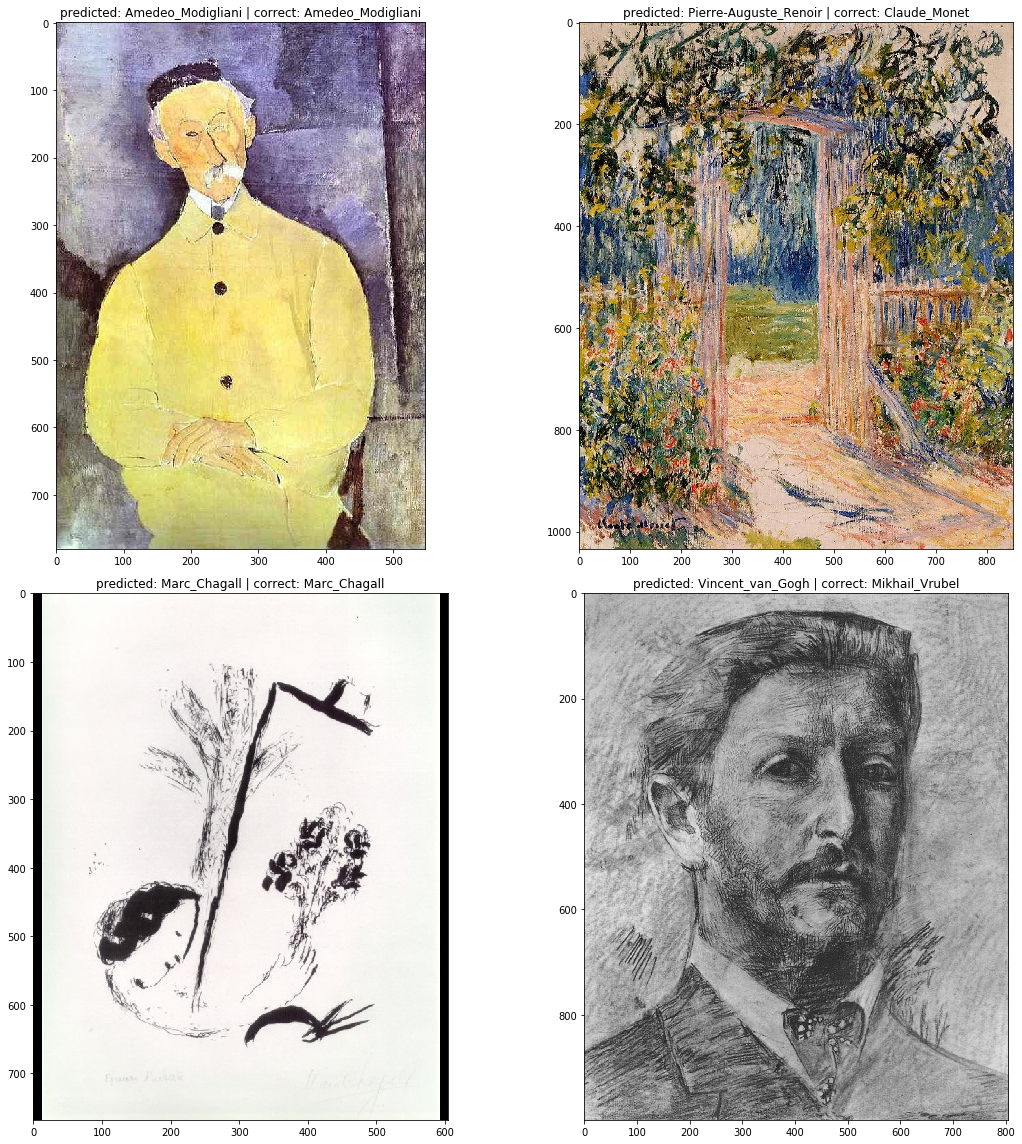

In [ ]:
device = utils.get_device()
titles, images = list(zip(*read_random_images(ALL_IMAGES)))
titles = list(map(lambda x: x.rsplit(":")[0], titles))
show_prediction(model, class_names=class_names, titles=titles, images=images, device=device)


Additionally with SupervisedRunner, you can easily predict entire loader with only one method call. <br/>
The resulting object has shape = (number of elements in the loader, output shape from the model)

In [ ]:
predictions = runner.predict_loader(
    model, loaders["valid"],
    resume=f"{logdir}/checkpoints/best.pth", verbose=True
)
print(predictions.shape)

print("logits: ", predictions[0])

probabilities = torch.softmax(torch.from_numpy(predictions[0]), dim=0)
print("probabilities: ", probabilities)

label = probabilities.argmax().item()
print(f"predicted: {class_names[label]}")

=> loading checkpoint ./logs/classification/checkpoints/best.pth
loaded checkpoint ./logs/classification/checkpoints/best.pth (epoch 4)

1/1 * Epoch (infer):   0% 0/26 [00:00<?, ?it/s]
1/1 * Epoch (infer):   0% 0/26 [00:04<?, ?it/s]
1/1 * Epoch (infer):   4% 1/26 [00:04<01:48,  4.32s/it]
1/1 * Epoch (infer):   4% 1/26 [00:04<01:48,  4.32s/it]
1/1 * Epoch (infer):   8% 2/26 [00:04<01:14,  3.12s/it]
1/1 * Epoch (infer):   8% 2/26 [00:04<01:14,  3.12s/it]
1/1 * Epoch (infer):  12% 3/26 [00:04<00:51,  2.24s/it]
1/1 * Epoch (infer):  12% 3/26 [00:04<00:51,  2.24s/it]
1/1 * Epoch (infer):  15% 4/26 [00:04<00:35,  1.61s/it]
1/1 * Epoch (infer):  15% 4/26 [00:08<00:35,  1.61s/it]
1/1 * Epoch (infer):  19% 5/26 [00:08<00:44,  2.13s/it]
1/1 * Epoch (infer):  19% 5/26 [00:08<00:44,  2.13s/it]
1/1 * Epoch (infer):  23% 6/26 [00:08<00:30,  1.54s/it]
1/1 * Epoch (infer):  23% 6/26 [00:08<00:30,  1.54s/it]
1/1 * Epoch (infer):  27% 7/26 [00:08<00:22,  1.18s/it]
1/1 * Epoch (infer):  27% 7/26 [00:08<0

## Model tracing

Catalyst allows you to use Runner to make [tracing](https://pytorch.org/docs/stable/jit.html) models.

> How to do this in the Config API, we wrote in [our blog (issue \#2)](https://github.com/catalyst-team/catalyst-info#catalyst-info-2-tracing-with-torchjit)

For this purpose it is necessary to pass in a method `trace ` model and a batch on which `predict_batch ` will be executed:

In [ ]:
batch = next(iter(loaders["valid"]))
# saves to `logdir` and returns a `ScriptModule` class
runner.trace(model=model, batch=batch, logdir=logdir, fp16=is_fp16_used)

!ls {logdir}/trace/

RuntimeError: ignored

After this, you can easily load the model and predict anything!

In [ ]:
if is_fp16_used:
    model = utils.load_traced_model(f"{logdir}/trace/traced-forward-opt_O1.pth", device="cuda", opt_level="O1")
else:
    model = utils.load_traced_model(f"{logdir}/trace/traced-forward.pth", device="cpu")

In [ ]:
model_input = batch["features"].to("cuda" if is_fp16_used else "cpu")
model.forward(model_input)

### Advanced: Custom Callbacks

Let's count the number of predicted labels per class.

In [ ]:
import collections

from catalyst.dl import Callback, CallbackOrder, RunnerState


class CustomInferCallback(Callback):
  def __init__(self):
    super().__init__(CallbackOrder.Internal)
    self.class_counts = collections.defaultdict(lambda: 0)

  def on_loader_start(self, state: RunnerState):
    self.class_counts = collections.defaultdict(lambda: 0)

  def on_batch_end(self, state: RunnerState):
    # data from the Dataloader
    # features, targets = state.input["features"], state.input["targets"]
    logits = state.output["logits"]

    labels = logits.argmax(axis=1)
    labels = labels.cpu().detach().numpy().tolist()
    for label in labels:
        self.class_counts[label] += 1


In [ ]:
from collections import OrderedDict
from catalyst.dl.callbacks import CheckpointCallback

infer_loaders = {"infer": loaders["valid"]}
model = get_model(model_name, num_classes)

device = utils.get_device()
if is_fp16_used:
    fp16_params = dict(opt_level="O1") # params for FP16
else:
    fp16_params = None

runner = SupervisedRunner(device=device)
runner.infer(
    model=model,
    loaders=infer_loaders,
    callbacks=OrderedDict([
        ("loader", CheckpointCallback(resume=f"{logdir}/checkpoints/best.pth")),
        ("infer", CustomInferCallback())
    ]),
    fp16=fp16_params,
)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

class_counts = runner.callbacks["infer"].class_counts
counts = [class_counts[x] for x in range(len(class_names))]

plt.figure(figsize=(20, 9))
x = np.arange(len(counts))
plt.bar(x + 0.5, height=counts)
plt.xticks(x - 0.3, class_names, rotation=65)
plt.show()

### Advanced: Training with Focal Loss and OneCycle

In the `catalyst.contrib` there are a large number of different additional criterions, models, layers etc

For example,

[catalyst.contrib.criterion](https://catalyst-team.github.io/catalyst/api/contrib.html#module-catalyst.contrib.criterion.ce):
- HuberLoss
- CenterLoss
- FocalLossMultiClass
- DiceLoss / BCEDiceLoss
- IoULoss / BCEIoULoss
- LovaszLossBinary / LovaszLossMultiClass / LovaszLossMultiLabel
- WingLoss

Lr scheduler in [catalyst.contrib.schedulers](https://catalyst-team.github.io/catalyst/api/contrib.html#module-catalyst.contrib.schedulers.base):
- OneCycleLRWithWarmup

Moreover, in [catalyst.contrib.models](https://catalyst-team.github.io/catalyst/api/contrib.html#models) you can find various models for segmentation:
- Unet / ResnetUnet
- Linknet / ResnetLinknet
- FPNUnet / ResnetFPNUnet
- PSPnet / ResnetPSPnet
- MobileUnet


Finally, several handwritten modules in [catalyst.contrib.modules](https://catalyst-team.github.io/catalyst/api/contrib.html#module-catalyst.contrib.modules.common):
- Flatten
- TemporalAttentionPooling
- LamaPooling
- NoisyLinear
- GlobalAvgPool2d / GlobalMaxPool2d
- GlobalConcatPool2d / GlobalAttnPool2d

a bunch of others


But for now, let's take `FocalLoss` and `OneCycleLRWithWarmup` to play around.

In [ ]:
from catalyst.contrib.criterion import FocalLossMultiClass
from catalyst.contrib.schedulers import OneCycleLRWithWarmup

logdir = "./logs/classification_tutorial_1"
num_epochs = 10

model = get_model(model_name, num_classes)

criterion = FocalLossMultiClass()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
scheduler = OneCycleLRWithWarmup(
    optimizer, 
    num_steps=num_epochs, 
    lr_range=(0.001, 0.0001),
    warmup_steps=1
)

# FocalLoss expects one_hot for the input
# in our Reader function we have already created the conversion of targets in one_hot
# so, all we need - respecify the target key name
runner = SupervisedRunner(input_target_key="targets_one_hot")

In [ ]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    callbacks=[
        AccuracyCallback(num_classes=num_classes),
        AUCCallback(
            num_classes=num_classes,
            input_key="targets_one_hot",
            class_names=class_names
        ),
        F1ScoreCallback(
            input_key="targets",
            activation="Softmax"
        )
    ],
    logdir=logdir,
    num_epochs=num_epochs,
    main_metric="auc/_mean",
    minimize_metric=False,
    fp16=fp16_params,
    verbose=True
)

In [ ]:
# it can take a while (colab issue)
utils.plot_metrics(
    logdir=logdir, 
    metrics=["loss", "accuracy01", "auc/_mean", "f1_score", "_base/lr"]
)

In [ ]:
device = utils.get_device()
titles, images = list(zip(*read_random_images(ALL_IMAGES)))
titles = list(map(lambda x: x.rsplit(":")[0], titles))
show_prediction(model, class_names=class_names, titles=titles, images=images, device=device)

### Advanced:  Balancing classes in the dataset

There are several useful data-sampler implementations in the `catalyst.data.sampler`. For example,
- `BalanceClassSampler` allows you to create stratified sampling on an unbalanced dataset. <br/> A strategy can be either downsampling, upsampling or some prespeficied number of samples per class. <br/> Very important feature for every classification problem.
- `MiniEpochSampler` allows you to split your "very large dataset" and sample some small portion of it every epoch. <br/> This is useful for those cases where you need to check valid metrics and save checkpoints more often. <br/> For example, your 1M images dataset can be sampled in 100k per epoch with all necessary metrics.

In [ ]:
from catalyst.data.sampler import BalanceClassSampler

logdir = "./logs/classification_tutorial_2"
num_epochs = 10

labels = [x["label"] for x in train_data]
sampler = BalanceClassSampler(labels, mode="upsampling")

# let's re-create our loaders with BalanceClassSampler
loader = get_loaders(open_fn, train_data_transforms, valid_data_transforms, sampler=sampler)

model = get_model(model_name, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
scheduler = OneCycleLRWithWarmup(
    optimizer, 
    num_steps=num_epochs, 
    lr_range=(0.001, 0.0001),
    warmup_steps=1
)

runner = SupervisedRunner()

In [ ]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    callbacks=[
        AccuracyCallback(num_classes=num_classes),
        AUCCallback(
            num_classes=num_classes,
            input_key="targets_one_hot",
            class_names=class_names
        ),
        F1ScoreCallback(
            input_key="targets",
            activation="Softmax"
        )
    ],
    logdir=logdir,
    num_epochs=num_epochs,
    main_metric="auc/_mean",
    minimize_metric=False,
    fp16=fp16_params,
    verbose=True
)

In [ ]:
# it can take a while (colab issue)
utils.plot_metrics(
    logdir=logdir, 
    metrics=["loss", "accuracy01", "auc/_mean", "f1_score", "_base/lr"]
)

In [ ]:
device = utils.get_device()
titles, images = list(zip(*read_random_images(ALL_IMAGES)))
titles = list(map(lambda x: x.rsplit(":")[0], titles))
show_prediction(model, class_names=class_names, titles=titles, images=images, device=device)